In [3]:
# First, download and extract the dataset properly
import os
import zipfile
from tensorflow.keras.utils import get_file

# Download the dataset (Dogs vs Cats from Kaggle)
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d salader/dogs-vs-cats


Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 99% 1.06G/1.06G [00:10<00:00, 149MB/s]
100% 1.06G/1.06G [00:10<00:00, 112MB/s]


In [4]:
# Extract the dataset
with zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')



In [5]:
# Verify the directory structure
!ls /content
!ls /content/train
!ls /content/test

dogs_vs_cats	  download.jpg	sample_data  train
dogs-vs-cats.zip  kaggle.json	test
cats  dogs
cats  dogs


In [6]:
# Now update your data paths
train_dir = '/content/train'
validation_dir = '/content/test'

# Verify these directories exist
assert os.path.exists(train_dir), f"Training directory not found at {train_dir}"
assert os.path.exists(validation_dir), f"Validation directory not found at {validation_dir}"


In [7]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

In [8]:
# Step 1: Data Preparation
# Assuming the dataset is already downloaded and extracted (from the first PDF)
train_dir = '/content/train'
validation_dir = '/content/test'

In [9]:
# Rest of your code remains the same...
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [10]:
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow images in batches
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


In [11]:
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 5000 images belonging to 2 classes.


In [12]:
# Step 2: Transfer Learning with Pre-trained Models

# First model: VGG16
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model
    base_model.trainable = False

    # Create new model on top
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

vgg_model = create_vgg16_model()
vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
# Train the VGG16 model
history_vgg = vgg_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 311s 477ms/step - accuracy: 0.7727 - loss: 0.4578 - val_accuracy: 0.9066 - val_loss: 0.2243
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 285s 455ms/step - accuracy: 0.8782 - loss: 0.2805 - val_accuracy: 0.9132 - val_loss: 0.2117
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 285s 455ms/step - accuracy: 0.8825 - loss: 0.2685 - val_accuracy: 0.9236 - val_loss: 0.1849
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 335s 477ms/step - accuracy: 0.8921 - loss: 0.2501 - val_accuracy: 0.9214 - val_loss: 0.1870
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 283s 453ms/step - accuracy: 0.8887 - loss: 0.2552 - val_accuracy: 0.9268 - val_loss: 0.1773
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 284s 454ms/step - accuracy: 0.8944 - loss: 0.2496 - val_accuracy: 0.9264 - val_loss: 0.1750
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 283s 453ms/step - accuracy: 0.8925 - loss: 0.2473 - val_accuracy: 0.9086 - val_loss: 0.2182
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 285s 455ms/step - accuracy: 0.8879 -

In [14]:
# Second model: MobileNetV2
def create_mobilenet_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model
    base_model.trainable = False
     # Create new model on top
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

mobilenet_model = create_mobilenet_model()
mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
# Train the MobileNetV2 model
history_mobilenet = mobilenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 250s 384ms/step - accuracy: 0.9454 - loss: 0.1277 - val_accuracy: 0.9696 - val_loss: 0.0766
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 236s 378ms/step - accuracy: 0.9695 - loss: 0.0726 - val_accuracy: 0.9808 - val_loss: 0.0538
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 236s 378ms/step - accuracy: 0.9749 - loss: 0.0639 - val_accuracy: 0.9774 - val_loss: 0.0565
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 235s 376ms/step - accuracy: 0.9731 - loss: 0.0663 - val_accuracy: 0.9808 - val_loss: 0.0507
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 236s 378ms/step - accuracy: 0.9751 - loss: 0.0625 - val_accuracy: 0.9774 - val_loss: 0.0616
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 236s 378ms/step - accuracy: 0.9755 - loss: 0.0602 - val_accuracy: 0.9808 - val_loss: 0.0552
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 237s 379ms/step - accuracy: 0.9760 - loss: 0.0597 - val_accuracy: 0.9788 - val_loss: 0.0631
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 236s 377ms/step - accuracy: 0.9758 -

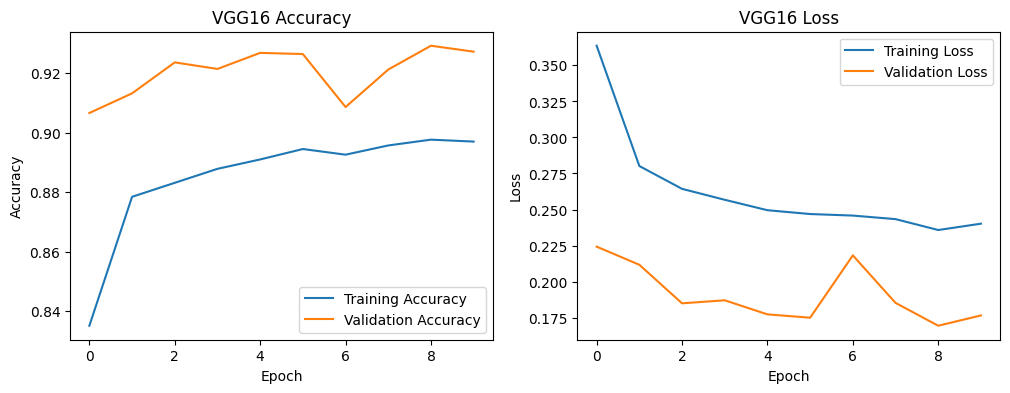

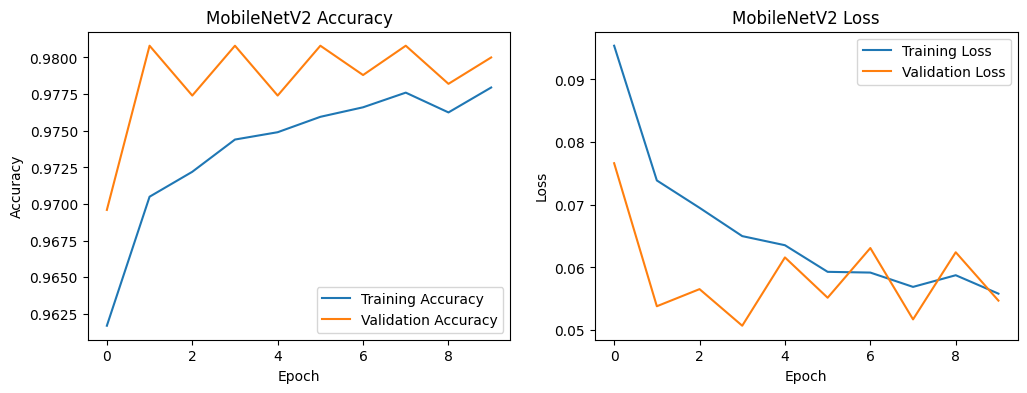

In [16]:

# Plot training history
def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history_vgg, 'VGG16')
plot_history(history_mobilenet, 'MobileNetV2')

# Save the best model (MobileNetV2 in this case)
mobilenet_model.save('cats_dogs_mobilenet.h5')